# Project: Predicting Boston Housing Prices
## Model Evaluation & Validation

## Intro
In this project, the goal is to evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

Run the code cell below to load the Boston housing dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals_py3 as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print ("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))
#print data
#print list(features)

Boston housing dataset has 489 data points with 4 variables each.


/Users/udothemath1984/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Data Exploration
Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
We start it with calculating the descriptive statistics about the Boston housing prices. Since `numpy` has already been imported for you, use this library to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In practice, the missing data is replaced by the mean, median, or mode of the features(attribute), and more sophisticated approach also exists.   
**Note:** Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.


In [5]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print ("Statistics for Boston housing dataset:\n")
print ("Minimum price: ${:,.2f}".format(minimum_price))
print ("Maximum price: ${:,.2f}".format(maximum_price))
print ("Mean price: ${:,.2f}".format(mean_price))
print ("Median price ${:,.2f}".format(median_price))
print ("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### Feature Observation
Three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.
  
**Note:** Before digging into the problem, we should spend some time on understanding the data itself. For instance, using our intuition, would you expect a home that has an `'RM'` value of 6 be worth more or less than a home that has an `'RM'` value of 7?

**Thought:** I believe the value of MEDV increases while RM increases. The larger RM it is, it is very likely the house has more space so that the price (MEDV) is higher. The MEDV is lower with larger LSTAT. It is very possible that house owner as lower class cannot afford too much for their house. For low PTRATIO region, MEDV should be high. For the house nearby the schools where the children can have better education (low PTRATIO), the price of the house (MEDV) should be high. In summary, low MEDV could be expected with small RM, large LSTAT, and large PTRATIO. MEDV should increase with increasing RM, decreasing LSTAT, and decreasing PTRATIO.




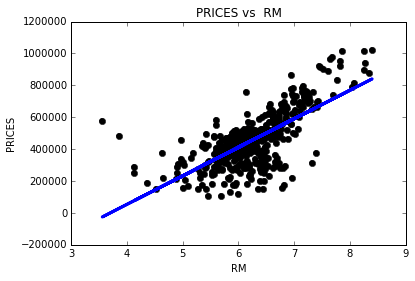

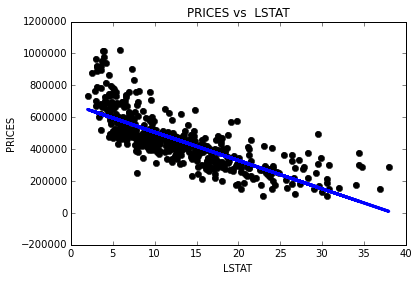

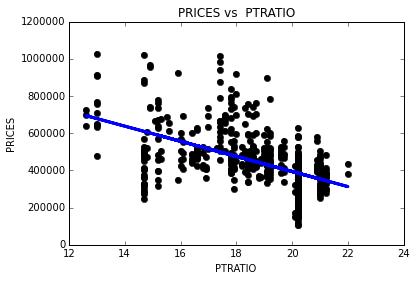

In [9]:
import matplotlib.pyplot as plt
import numpy as np

for col in features.columns:

    fig, ax = plt.subplots()
    fit = np.polyfit(features [col], prices, deg=1) # We use a linear fit to compute the trendline
    ax.scatter(features [col],  prices)
    plt.plot(features [col], prices, 'o', color='black')
    ax.plot(features[col], fit[0] * features[col] + fit[1], color='blue', linewidth=3) # This plots a trendline with the regression parameters computed earlier. We should plot this after the dots or it will be covered by the dots themselves
    plt.title('PRICES vs  '+ str(col)) # title here
    plt.xlabel(col) # label here
    plt.ylabel('PRICES') # label here

----

## Developing a Model
After the basic investigation of the data, we could move on to develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, I calculate the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify the model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, I implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [6]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

**Note:** Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination to examine whether the model have successfully captured the variation of the target variable.

Model has a coefficient of determination, R^2, of 0.923.


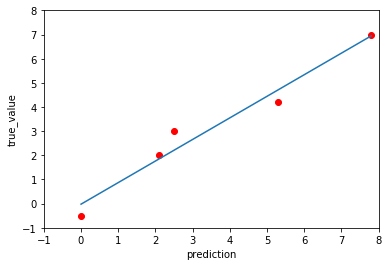

In [20]:
# Calculate the performance of this model
true_value = [3, -0.5, 2, 7, 4.2]
prediction = [2.5, 0.0, 2.1, 7.8, 5.3]
score = performance_metric(true_value, prediction)
print ("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

import matplotlib.pyplot as plt

plt.xlim(-1, 8)
plt.ylim(-1, 8)
plt.xlabel("prediction")
plt.ylabel("true_value")
plt.plot(prediction, true_value, 'o', color="R")
plt.plot(np.unique(prediction), np.poly1d(np.polyfit(prediction, true_value, 1))(np.unique(prediction)))
plt.show()

## Ref: Best Fit One-Liner
## https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

**Thought:** Yes. The obtained R squared value is 0.923, and I would consider the model have successfully captured the vraition of the target variable. 92.3% of the variation in true_value is determined by the linear relationship between true_value and prediction.

### Implementation: Shuffle and Split Data
Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to an arbitrary value. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [10]:
# Import 'train_test_split'
from sklearn.cross_validation import train_test_split 

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=0)

# Success
print ("Training and testing split was successful.")

Training and testing split was successful.


### Training and Testing
We want to avoid underfitting and overfitting by splitting a dataset into training and testing subsets. By doing so, one could validate our model so that the model can be used to predict the new unseen data.

----

## Analyzing Model Performance
In this third section of the project, I compare several models' learning and testing performances on various subsets of training data. Additionally, I investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing the model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

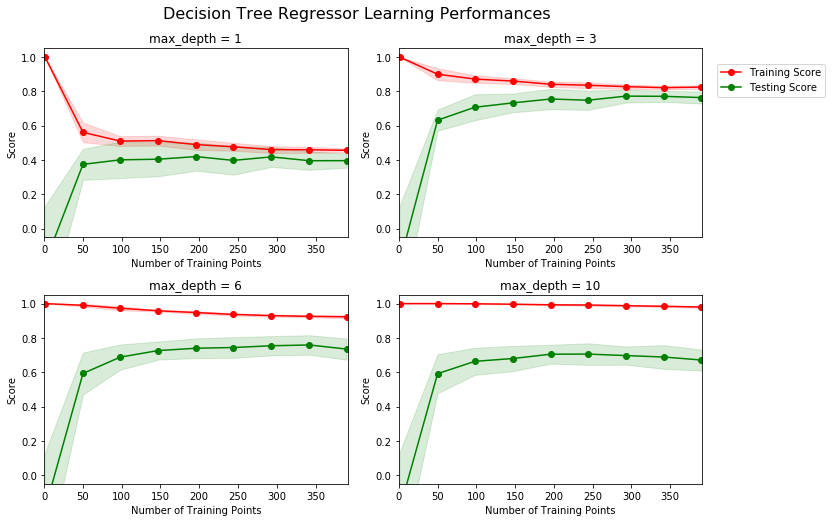

In [11]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Model Complexity Discussion
For the graph with max_depth equals 3, the score of the training curve decreases and the score of the testing curve increases as more training points are added. Having more training points benefits the model only when number of training points is below around 200. For training points above 200, giving more training points doesn't benefit the model. Comparing these four models, one should consider the model with max_depth = 3 because training score and testing score converge to a relatively acceptable score (around 80).

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

Run the code cell below and use this graph to answer the following two questions.

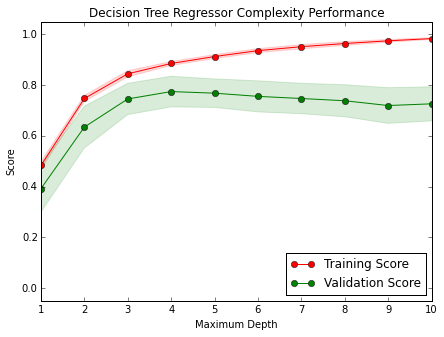

In [14]:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff
The model with max_depth = 1 suffers from high bias. The score is below 0.5 for training and 0.4 for validation where the model doesn't predict well. On the other hand, the model with max_depth = 10 suffers from high variance. The score is improved that training score is around 0.98 and validation score is around 0.75. The model becomes high variance due to high model complexity that the score at max_depth = 3 is very different.

### Best-Guess Optimal Model
I think the model with max_depth = 3 (or 4), is most likely being the best one among others. By viewing the figure of decision tree complexity performance, the score isn't improved with max_depth larger than 4.

-----

## Evaluating Model Performance
Construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search
For machine learning approach, parameters (or hyperparameters) of the model play an important role to determine its capability. In order to find the best setting of the parameters, one can implement grid search technique to run through possible values and consider the optimal parameters for the model.  
Moreover, there are other techniques that could be used for hyperparameter optimization in order to save time like RandomizedSearchCV, in this case instead of exploring the whole parameter space just a fixed number of parameter settings is sampled from the specified distributions. This proves useful when we need to save time but is not necessary in cases like ours where the data set is relatively small.

### Implementation: Cross-Validation
In order to validate the model, the entire data is splitted into training and testing data. However, the model with one particular way of splitting the data might affect its universality. By k-fold cross-validation, one can cancel out such effect so that the outcoming model is generalized.
For instance, we apply k-fold cross-validation training technique by equally dividing entire data into k samples, where a single sample is considered as testing set and k-1 samples are training set. For each partition the model is trainned, and therefore all the data can be used for training and validation. Finally, the results from k-fold approach are averaged, becoming our ultimate estimation.  
  
Reference:  
- [wiki-page cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics&#41;#k-fold_cross-validation)  
- [http://www.anc.ed.ac.uk/rbf/intro/node16.html](http://www.anc.ed.ac.uk/rbf/intro/node16.html)


### Implementation: Fitting a Model
I bring everything together and train a model using the **decision tree algorithm**. To ensure that it is an optimized model, I train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, I use `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique you describe previously, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While you're working on your implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

Please note that ShuffleSplit has different parameters in scikit-learn versions 0.17 and 0.18.
For the `fit_model` function in the code cell below, I do the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [12]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

# This can be omitted.
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    # 0.17
    # http://lijiancheng0614.github.io/scikit-learn/modules/generated/sklearn.cross_validation.ShuffleSplit.html
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[x for x in range(1,11)]}
    # print params

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_
    #return grid.best_estimator_, grid.grid_scores_

/Users/udothemath1984/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Optimal Model

In [14]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print ("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

#reg, entire_net = fit_model(X_train, y_train)
#print "Entire net of Parameter 'max_depth' is {}".format(entire_net)


Parameter 'max_depth' is 4 for the optimal model.


**Thought:** Parameter 'max_depth' is 4 for the optimal model, which is consistent with the previous guess. In learning curves section, four cases where max_depth equals 1, 3, 6, and 10 are provided. Based on these available data, one might pick max_depth=3 as the best model. However, it is better to run the grid search approach in order to determine/evaluate the best hyperparameter. (In our case, 'max_depth' is 4 for the optimal model.)

### Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |
*What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?*  

In [15]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print ("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $391,183.33
Predicted selling price for Client 2's home: $189,123.53
Predicted selling price for Client 3's home: $942,666.67


**Prediction**: 
+ Predicted selling price for Client 1's home: \$391,183.33
+ Predicted selling price for Client 2's home: \$189,123.53 
+ Predicted selling price for Client 3's home: \$942,666.67

I feel that the prediction is very consistent with my intuition. For the case of client 3, there is 8 rooms, which indicates that the size of the house is very likely to be bigger than the other two cases. Moreover, with such a low neighborhood poverty level (3 %) and low student-teacher ratio of nearby schools (12-to-1), these features should also increase the housing price. For the case of client 2, it has very high neighborhood poverty level and high student-teacher ratio of nearby schools, the expected value of such house should be low. Finally, concidering the mean price around 454000, 5 rooms, 17 % poverty level, and 15-to-1 student teacher ratio from the case of client 1, these features reflect the moderate or slightly-below-moderate conditions and its housing price.  


### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [17]:
import visualsMODs as vs_mod
trial_prices = vs_mod.PredictTrials_trials(features, prices, fit_model, client_data, 100)

print ("\nRange in prices: ${:,.2f}".format(max(trial_prices) - min(trial_prices)))
print ("Mean in prices: ${:,.2f}".format(np.mean(trial_prices)))
print ("Standard deviation in prices: ${:,.2f}".format(np.std(trial_prices)))

Total Trial 100. You are at Trial 10.
Total Trial 100. You are at Trial 20.
Total Trial 100. You are at Trial 30.
Total Trial 100. You are at Trial 40.
Total Trial 100. You are at Trial 50.
Total Trial 100. You are at Trial 60.
Total Trial 100. You are at Trial 70.
Total Trial 100. You are at Trial 80.
Total Trial 100. You are at Trial 90.
Total Trial 100. You are at Trial 100.

Range in prices: $124,687.50
Mean in prices: $404,460.49
Standard deviation in prices: $22,927.16


(array([  2.,   1.,   3.,   2.,   0.,   1.,   2.,  21.,  54.,  14.]),
 array([ 306337.5 ,  318806.25,  331275.  ,  343743.75,  356212.5 ,
         368681.25,  381150.  ,  393618.75,  406087.5 ,  418556.25,  431025.  ]),
 <a list of 10 Patch objects>)

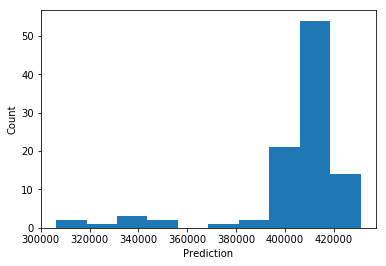

In [18]:
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.hist(trial_prices, 10)

*** <font color='red'>Thought:</font> *** To assess if the prediction is reasonable, besides from comparing it with the median, the mean and checking if it is included in one standard deviation range, you could use SKlearn to find the nearest neighbours of the feature vector. You can then contrast your results with the closest neighbours, the ones that have similar characteristics.  
[http://scikit-learn.org/stable/modules/neighbors.html#finding-the-nearest-neighbors](http://scikit-learn.org/stable/modules/neighbors.html#finding-the-nearest-neighbors)

In [20]:
from sklearn.neighbors import NearestNeighbors
num_neighbors=5
def nearest_neighbor_price(x):
    def find_nearest_neighbor_indexes(x, X):  # x is your vector and X is the data set.
        neigh = NearestNeighbors( num_neighbors )
        neigh.fit(X)
        distance, indexes = neigh.kneighbors( [x] )
        return indexes
    indexes = find_nearest_neighbor_indexes(x, features)
    sum_prices = []
    for i in indexes:
        sum_prices.append(prices[i])
    neighbor_avg = np.mean(sum_prices)
    return neighbor_avg
index = 0  
for i in client_data:
    val=nearest_neighbor_price(i)
    index += 1
    print "The predicted {} nearest neighbors price for home {} is: ${:,.2f}".format(num_neighbors,index, val)

The predicted 5 nearest neighbors price for home 1 is: $372,540.00
The predicted 5 nearest neighbors price for home 2 is: $162,120.00
The predicted 5 nearest neighbors price for home 3 is: $897,120.00


### Applicability
*** <font color='red'>Reflection:</font> *** Is the model reliable in a real-world setting?
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

**Thought:** The constructed model could not be used directly in a real-world setting. As indicating in hint, we cannot simply implement the model constructing by 1978 dataset and apply on today's market. However, one might build the model with these features and use such model to make preliminary prediction. Although the features RM, LSTAT, and PTRATIO can affect the housing price, I think these are not sufficient because there are other features having the direct impact on the housing price. For instance, the recent sale price in the surrounding of the house should provide the most representative information. One shuld expect alike price if given criteria are similar. If this type of data is not available, I believe one might consider other info such as the distance to the nearest subway station, bus stop, or park as the features of the model. With more sophisticated consideration of the feature, one might enhance the confidence of the model. If the model is over-simplified, the prediction might differ a lot from one trial to another. One can always increase the number of trial and investigate its distribution. With more running trials, the average of these trials could become more reliable than a single run. Finally, the expectation of housing price should be very different from urban city to rural city. One might want to apply supervised learning if the area is provided or unsupervised learning if the area isn't provided, the clustering of the subset by differentiating area should be considered as a preprocessing step. Then the reliability of the model could be improved. 